<a href="https://colab.research.google.com/github/kicysh/final_task_of_world_model_lecture_2021/blob/main/src/LDVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pip

In [1]:
!pip install scanpy scikit-misc

     |████████████████████████████████| 2.0 MB 31.5 MB/s 
     |████████████████████████████████| 8.8 MB 27.0 MB/s 
     |████████████████████████████████| 86 kB 7.7 MB/s 
     |████████████████████████████████| 96 kB 7.3 MB/s 
     |████████████████████████████████| 1.1 MB 50.8 MB/s 
     |████████████████████████████████| 63 kB 2.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=1c97414607c67f9d9be54f284eadaed97447cdb771b66dbeb1c69e0ec379adfa
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=3fd7eb5d844ff130fe92ee6b612cf4f82a5167739edd53e360c1a3414df9de0e
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=a8083e11d4df0a06bfd85df9cb7e1705be7d0245c29f

# data

In [2]:
!mkdir data figures
!gsutil cp gs://h5ad/2019-02-Pijuan-Sala-et-al-Nature/pijuan_sala_atlas.h5ad /content/data
path_of_data = '/content/data/pijuan_sala_atlas.h5ad'


Copying gs://h5ad/2019-02-Pijuan-Sala-et-al-Nature/pijuan_sala_atlas.h5ad...
\ [1 files][  1.0 GiB/  1.0 GiB]   31.9 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


# setting


In [3]:
# setting
SETTING_BATCHNORM_EPS = 0.001
SETTING_BATCHNORM_MOMENTUM = 0.01
SETTING_ENCODER_Z_DROPOUT_P = 0.1
SETTING_ENCODER_L_DROPOUT_P = 0.1
SETTING_HIDDEN_DIM = 128
SETTING_EPS = 1e-8

USE_CUDA = True
SETTING_BATCH_SIZE = 256

# model

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import logsumexp
from torch.distributions import Normal, kl_divergence

import matplotlib.pyplot as plt

rng = np.random.RandomState(1234)
random_state = 42


In [5]:
import scanpy as sc
adata = sc.read_h5ad(path_of_data)
adata

AnnData object with n_obs × n_vars = 139331 × 29452
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster'
    var: 'gene_name'

In [6]:
idx = adata.obs.query('not doublet').index
#idx = np.random.choice(idx, 20000, replace=False)
adata = adata[idx]
sc.pp.highly_variable_genes(adata,n_top_genes=1000 ,flavor='seurat_v3')
print(adata)
#sc.pp.filter_genes(adata, min_cells=100)


/usr/local/lib/python3.7/dist-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


AnnData object with n_obs × n_vars = 125775 × 29452
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'


In [7]:
gene_index = adata.var[adata.var['highly_variable']].index

In [8]:
adata_df = adata.to_df()[gene_index]

In [77]:
#from math import ldexp

class LDVAE(nn.Module):
    """
    :param genes_cnt: Number of input genes
    :param latent_dim: Dimensionality of the latent space 
    """
    def __init__(
        self,
        genes_cnt: int, 
        latent_dim: int = 20
    ):
        super(LDVAE,self).__init__()
        self.local_l_mean = None
        self.local_l_std = None
        self.eps = SETTING_EPS

        self.theta = nn.Parameter(torch.randn(genes_cnt))
        self.encoder_z = nn.Sequential(
            nn.Linear(genes_cnt, SETTING_HIDDEN_DIM),
            nn.BatchNorm1d(SETTING_HIDDEN_DIM,
                           eps=SETTING_BATCHNORM_EPS, 
                           momentum=SETTING_BATCHNORM_MOMENTUM),
            nn.ReLU(),
            nn.Dropout(SETTING_ENCODER_Z_DROPOUT_P)
        )
        self.encoder_z_mean = nn.Linear(SETTING_HIDDEN_DIM,latent_dim)
        self.encoder_z_std = nn.Linear(SETTING_HIDDEN_DIM,latent_dim)

        self.encoder_l = nn.Sequential(
            nn.Linear(genes_cnt, SETTING_HIDDEN_DIM),
            nn.BatchNorm1d(SETTING_HIDDEN_DIM,
                           eps=SETTING_BATCHNORM_EPS, 
                           momentum=SETTING_BATCHNORM_MOMENTUM),
            nn.ReLU(),
            nn.Dropout(SETTING_ENCODER_L_DROPOUT_P)
        )
        self.encoder_l_mean = nn.Linear(SETTING_HIDDEN_DIM, 1)
        self.encoder_l_std = nn.Linear(SETTING_HIDDEN_DIM, 1)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, genes_cnt,bias=False),#bias=False
            nn.BatchNorm1d(genes_cnt,
                           eps=SETTING_BATCHNORM_EPS, 
                           momentum=SETTING_BATCHNORM_MOMENTUM)
        )


    def forward(self,x):
        x_z = self.encoder_z(x)
        z_mean = self.encoder_z_mean(x_z)
        z_std = torch.exp(torch.clip(self.encoder_z_std(x_z),max=10)) 
        #z = Normal(z_mean, z_std.sqrt()).rsample()
        z_eps = torch.randn(z_mean.shape).to('cuda' if next(self.parameters()).is_cuda else 'cpu')
        z = z_mean + z_std * z_eps


        x_l = self.encoder_l(x)
        l_mean = self.encoder_l_mean(x_l)
        l_std = torch.exp(torch.clip(self.encoder_l_std(x_l),max=10))
        #library = Normal(l_mean, l_std.sqrt()).rsample()
        l_eps = torch.randn(l_mean.shape).to('cuda' if next(self.parameters()).is_cuda else 'cpu')
        library = (l_mean + l_std * l_eps)

        y = self.decoder(z)
        y = torch.exp(torch.clip(library,max=10))*torch.softmax(y, dim=-1)
        return [z_mean, z_std, z], [l_mean, l_std, library], y


    def set_local_l_mean_and_std(self, data):
        masked_log_sum =np.ma.log(data.sum(axis=1))
        log_counts = masked_log_sum.filled(0)
        self.local_l_mean = (np.mean(log_counts).reshape(-1, 1)).astype(np.float32)[0][0]
        self.local_l_std = (np.var(log_counts).reshape(-1, 1)).astype(np.float32)[0][0]
        return self.local_l_mean, self.local_l_std


    def reconst_error(self,x, mu, theta):
        eps = SETTING_EPS
        log_theta_mu_eps = torch.log(theta + mu + eps)

        res = (
            theta * (torch.log(theta + eps) - log_theta_mu_eps)
            + x * (torch.log(mu + eps) - log_theta_mu_eps)
            + torch.lgamma(x + theta)
            - torch.lgamma(theta)
            - torch.lgamma(x + 1)
        )
        return res


    def loss(self,x):
        zs,ls,y = self.forward(x)
        z_mean, z_std, z = zs
        l_mean, l_std, library = ls

        mean, std = torch.zeros_like(z_mean), torch.ones_like(z_std)
        kl_z = kl_divergence(Normal(z_mean,torch.sqrt(z_std)), Normal(mean, std)).sum(dim=1)

        mean, std = self.local_l_mean*torch.ones_like(l_mean), self.local_l_std*torch.ones_like(l_std)
        kl_l = kl_divergence(Normal(l_mean,torch.sqrt(l_std)), Normal(mean, torch.sqrt(std))).sum(dim=1)

        reconst = self.reconst_error(x, mu=y, theta=torch.exp(self.theta)).sum(dim=-1)        
        return reconst, kl_l ,kl_z

In [78]:
model = LDVAE(genes_cnt = len(adata_df.columns),
              latent_dim = 20)
model.set_local_l_mean_and_std(adata_df.values)
model

LDVAE(
  (encoder_z): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (encoder_z_mean): Linear(in_features=128, out_features=20, bias=True)
  (encoder_z_std): Linear(in_features=128, out_features=20, bias=True)
  (encoder_l): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (encoder_l_mean): Linear(in_features=128, out_features=1, bias=True)
  (encoder_l_std): Linear(in_features=128, out_features=1, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
)

In [63]:
class GenesDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 adata, 
                 transform=None, 
                 target_transform=None):
        self.data = adata
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getattr__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        #label = self.img_labels.iloc[idx, 1]
        if self.transform:
            data = self.transform(data)
        #if self.target_transform:
        #    label = self.target_transform(label)
        return data

In [64]:
# dataloder
dataset = GenesDataset(adata_df.values)


n_samples = len(dataset) 
train_size = int(n_samples* 0.8)
val_size = int(n_samples * 0.2)
test_size = n_samples - train_size - val_size 

dataset_train ,dataset_valid, dataset_test = \
        torch.utils.data.random_split(dataset, [train_size, val_size,test_size])

dataloader_all = torch.utils.data.DataLoader(
    dataset,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=False
)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=True
)

#dataloader_test = torch.utils.data.DataLoader(
#    dataset_test,
#    batch_size=SETTING_BATCH_SIZE,
#    shuffle=True
#)

In [80]:
#from numpy.ma.core import nonzero
# train
#model = LDVAE(genes_cnt = len(adata_df.columns),
#              latent_dim = 20)
#model.set_local_l_mean_and_std(adata_df.values)
#model

n_epochs  = 10
optimizer = optim.Adam(model.parameters(), lr=7e-3)#  betas=(0.5,0.999))

device = 'cuda'  if USE_CUDA else 'cpu'
model.to(device)
#_x = nonzero

for epoch in range(n_epochs):
    losses = []

    model.train()
    for x in dataloader_train:
        x = x.to(device)
        #_x = x

        model.zero_grad()

        # forawrd and loss
        reconst, kl_l ,kl_z = model.loss(x)
        loss = torch.mean(-reconst+kl_l +kl_z)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())

    losses_val1 = []
    losses_val2 = []
    losses_val3 = []

    model.eval()
    for x in dataloader_valid:

        x = x.to(device)


        reconst, kl_l ,kl_z = model.loss(x)

        losses_val1.append(torch.mean(-reconst).cpu().detach().numpy())
        losses_val2.append(torch.mean(kl_l).cpu().detach().numpy())
        losses_val3.append(torch.mean(kl_z).cpu().detach().numpy())

    print('EPOCH: %d    Train Loss: %lf    Valid rec: %lf    Valid kl_l: %lf    Valid kl_z: %lf' %
            (epoch+1, np.average(losses),np.average(losses_val1),np.average(losses_val2),np.average(losses_val3)))


EPOCH: 1    Train Loss: 1026.945557    Valid rec: 769.402710    Valid kl_l: 1.640549    Valid kl_z: 11.522119
EPOCH: 2    Train Loss: 608.903748    Valid rec: 629.354736    Valid kl_l: 1.497651    Valid kl_z: 13.607798
EPOCH: 3    Train Loss: 567.734802    Valid rec: 531.874146    Valid kl_l: 1.280270    Valid kl_z: 13.567320
EPOCH: 4    Train Loss: 547.048157    Valid rec: 522.921814    Valid kl_l: 1.199071    Valid kl_z: 12.581568
EPOCH: 5    Train Loss: 535.288147    Valid rec: 508.924438    Valid kl_l: 1.161474    Valid kl_z: 13.040957
EPOCH: 6    Train Loss: 527.585632    Valid rec: 502.524902    Valid kl_l: 1.195366    Valid kl_z: 14.017503
EPOCH: 7    Train Loss: 522.997437    Valid rec: 496.473694    Valid kl_l: 1.080632    Valid kl_z: 13.005836
EPOCH: 8    Train Loss: 519.964844    Valid rec: 498.061737    Valid kl_l: 1.238120    Valid kl_z: 13.444982
EPOCH: 9    Train Loss: 517.674072    Valid rec: 497.282379    Valid kl_l: 1.147707    Valid kl_z: 13.507245
EPOCH: 10    Train

In [81]:
# w
import pandas as pd

_w = model.decoder[0].weight
bn = model.decoder[1]
sigma = torch.sqrt(bn.running_var + bn.eps)
gamma = bn.weight
b = gamma / sigma
bI = torch.diag(b)
loadings = torch.matmul(bI, _w)
loadings = loadings.detach().cpu().numpy()

W = pd.DataFrame(loadings, index=gene_index)
W.to_csv('/content/w.csv')


In [82]:
W

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
index,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000025902,0.043760,-0.416047,0.971108,0.503371,-0.483529,-0.044128,-0.301439,-0.134799,0.588240,-0.066571,-0.162269,0.970376,-0.481875,1.148691,-0.026570,0.224821,-0.219244,1.364738,-0.611001,0.508620
ENSMUSG00000025927,-0.066026,-0.599081,-0.014503,-0.526868,-0.735547,-0.818612,-0.630511,-0.223627,-0.025318,0.040036,-0.908018,-0.857526,0.232574,0.262158,-0.977915,-0.211783,1.104656,0.255547,-1.073875,-0.444747
ENSMUSG00000026124,-0.038316,0.075192,0.264806,-0.232803,0.687314,0.112645,-0.127864,-0.179363,0.404397,-0.004014,-0.227860,1.663598,0.731000,0.173833,-0.461086,0.792399,-0.768982,-0.060979,0.324077,0.107352
ENSMUSG00000026043,-0.093938,-0.345481,-0.199250,0.072805,0.364098,-0.281824,0.012055,0.082732,-0.128613,-0.030920,0.105550,-0.296384,1.809065,-0.506724,-0.020814,-0.430613,0.960450,-0.045480,0.195756,-0.049705
ENSMUSG00000045954,-0.039433,0.327487,0.055495,-0.231980,-0.235507,-0.013810,0.149755,0.078661,-0.416652,0.044944,-0.035803,-0.034384,1.209176,0.242843,0.080786,-0.682930,0.161902,-0.006404,0.196783,0.044463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000100417,0.025019,-0.121517,0.311006,-0.077574,-0.221576,-0.534528,0.087622,-0.204980,-0.050531,0.083501,-0.233648,-0.009967,0.038024,-0.129749,-0.002579,0.111409,0.031873,-0.302763,-0.017617,-0.090961
ENSMUSG00000025219,-0.038637,-0.273323,0.610058,1.043711,0.232788,-1.071999,0.080853,0.141706,0.487833,0.023619,-1.266126,1.500129,-0.119344,-0.362574,0.076627,0.132256,-0.142883,-0.868953,-0.158224,0.315646
ENSMUSG00000025068,-0.012112,0.065726,0.262182,-0.118172,-0.212177,0.212360,-0.116227,-0.258028,0.054962,0.012776,0.088360,-0.400662,-0.492624,-0.499442,0.134922,0.234156,0.205034,-0.554769,0.063420,-0.076929


In [83]:
latent_array  = None
model.eval()
for x in dataloader_all:
    x = x.to(device)
    _z,_,_ = model(x)
    z_mean,_,_ = _z
    z_mean = z_mean.cpu().detach().numpy()
    if latent_array is None:
        latent_array = z_mean
    else:
        latent_array = np.concatenate([latent_array, z_mean])
pd.DataFrame(latent_array,index=adata_df.index).to_csv('/content/z.csv')

In [84]:
pd.DataFrame(latent_array,index=adata_df.index)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
index,,,,,,,,,,,,,,,,,,,,
cell_1,-0.016835,0.214646,0.482642,-0.190331,-0.202818,-1.029704,0.502576,0.121715,-0.132451,0.033417,0.683671,-0.071905,0.080522,-0.145141,0.419900,0.558778,0.108757,-0.864511,-0.341943,0.178583
cell_2,-0.152179,-0.292185,0.955651,0.506546,0.223054,-0.588532,-0.208096,-0.382169,0.143324,0.025582,-0.270874,0.490253,-0.061526,-0.033772,-0.257043,-0.017544,-0.281470,-0.917010,-0.561928,-0.077718
cell_3,-0.354686,-1.248537,0.341757,-1.042033,0.302574,0.446138,0.070066,0.844798,-0.251913,0.071756,0.386126,0.904862,-1.378413,0.790220,-1.025853,0.448834,0.009850,0.752158,-0.440379,1.857602
cell_4,-0.028579,-0.358661,0.815440,0.184621,0.134759,-0.885022,-0.334812,-0.516562,-0.052106,-0.015390,-0.029004,0.750254,-0.290571,-0.036712,-0.066082,-0.371768,0.115619,-0.985248,-0.273613,1.120008
cell_5,0.020586,0.151749,0.377636,-0.163824,-0.621524,1.618299,0.243422,0.396159,-0.037873,-0.048389,0.755104,-0.797695,-0.743843,-0.088118,-0.169647,0.610802,1.222924,-0.865903,-0.541619,0.014708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_139327,-0.034071,-0.616520,-1.755083,0.155832,1.874307,-0.165900,-0.111959,0.850228,0.292040,-0.003065,0.135690,-1.750451,-0.724081,1.092203,0.011809,-0.736178,0.071417,-0.651503,0.137060,-0.058508
cell_139328,-0.069955,-0.687969,-0.195530,-0.404752,-0.199344,-0.279071,-1.080399,0.332194,-0.149530,0.051998,-0.794424,-0.894377,0.277270,0.152623,-0.297267,-0.000913,0.848288,0.322412,0.094960,0.397020
cell_139329,-0.076643,-0.483326,-0.797107,0.539979,0.822455,0.292002,0.962687,0.548309,0.020495,0.050950,-1.401205,0.140769,0.529479,-1.247435,0.862877,-0.327105,1.418883,0.353640,0.203528,1.078994


In [101]:
w_df = pd.read_csv('/content/w.csv', index_col=0)
z_df = pd.read_csv('/content/z.csv', index_col=0)

In [103]:
w_df = w_df.add_prefix('w')
z_df = z_df.add_prefix('z')

In [104]:
%pylab inline
%config InlineBackend.figure_format ='retina'

import time

import anndata
import matplotlib.colors as mcolors
import pandas as pd

import plotnine as p


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [106]:
def Z_covariance(Z):
    Zcentered = Z - Z.mean(0)
    Zscaled = Z / Z.std(0)
    ZTZ = np.cov(Zscaled.T)
    
    eigen_values, _ = np.linalg.eig(ZTZ)
    singular_values = np.sqrt(eigen_values)
    variance_explained = singular_values / singular_values.sum()

    return ZTZ, variance_explained

In [107]:
_, variance_explained = Z_covariance(z_df)
idx = np.argsort(variance_explained)[::-1]


In [108]:
Z_df_ordered = pd.DataFrame(z_df.values[:, idx]).add_prefix('z')
Z_df_ordered.index = z_df.index
W_df_ordered = pd.DataFrame(w_df.values[:, idx]).add_prefix('w')
W_df_ordered.index = w_df.index

In [109]:
adata = anndata.read('/content/data/pijuan_sala_atlas.h5ad')

In [110]:
W_df_ordered = adata.var.loc[W_df_ordered.index].join(W_df_ordered)

In [111]:


text_shift = {
    (0, 'Fst'): (0.2, -0.2),
    (0, 'Pmp22'): (-0.1, -0.3),
    (0, 'Hoxaas3'): (0.0, 0.3),
    (0, 'Acta2'): (0.0, 0.2),
    (0, 'Nnat'): (0.0, 0.5),
    (0, 'Ifitm1'): (0.0, 0.2),
    
    (1, 'Srgn'): (0., -0.2),
    (1, 'Amn'): (-0.7, 0.),
    
    (2, 'Crabp2'): (0.0, 0.4),
    (2, 'Tdgf1'): (0.0, 0.4),
    (2, 'Cer1'): (-0.6, 0.0),
    (2, 'T'): (-1.3, 0.0),
    
    (3, 'Cdx1'): (0.0, 0.4),
    (3, 'Cdx2'): (-1.0, 0.7),
    (3, 'Cited1'): (-1.6, -0.0),
    (3, 'Phlda2'): (-0.7, 0.0),
    (3, 'T'): (0.0, 0.2),
    (3, 'Ifitm1'): (-0.2, 0.0),
#     (3, 'Rspo2'): (-0.3, 0.0),
#     (3, 'Htr2c'): (0.6, 0.1),
#     (3, 'Col1a1'): (0.0, 0.2),
    
#     (4, 'Ttn'): (0.0, -0.4),
#     (4, 'Sntb1'): (0.0, -0.3),
#     (4, 'Colec12'): (-1.1, 0.1),
#     (4, 'Adam12'): (0.1, 0.4),
#     (4, 'Spon1'): (0.0, 0.2),
#     (4, 'Gm3764'): (-0.2, 0.3),
#     (4, 'C130071C03Rik'): (1.5, -0.35),
    
}



['2610528A11Rik', 'Tdo2', 'Hoxc10', 'Hoxa10', 'Hoxa9', 'Tnnt2', 'Ptprc', 'Hoxc9']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['Hoxa9', 'Tdgf1', 'Cdx4', 'Hoxb9', 'Hoxaas3', 'Hoxc8', 'Hoxa7', 'Eomes']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['Pax6', 'Tal2', 'Hes3', 'Rax', 'Six3', 'Slc7a3', 'Dlx5', 'Lhx5']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['Lum', 'Fezf1', 'Gal', 'Pax8', 'Wnt1', 'Tfap2b', 'En1', 'Sox10']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['1700011H14Rik', 'Utf1'

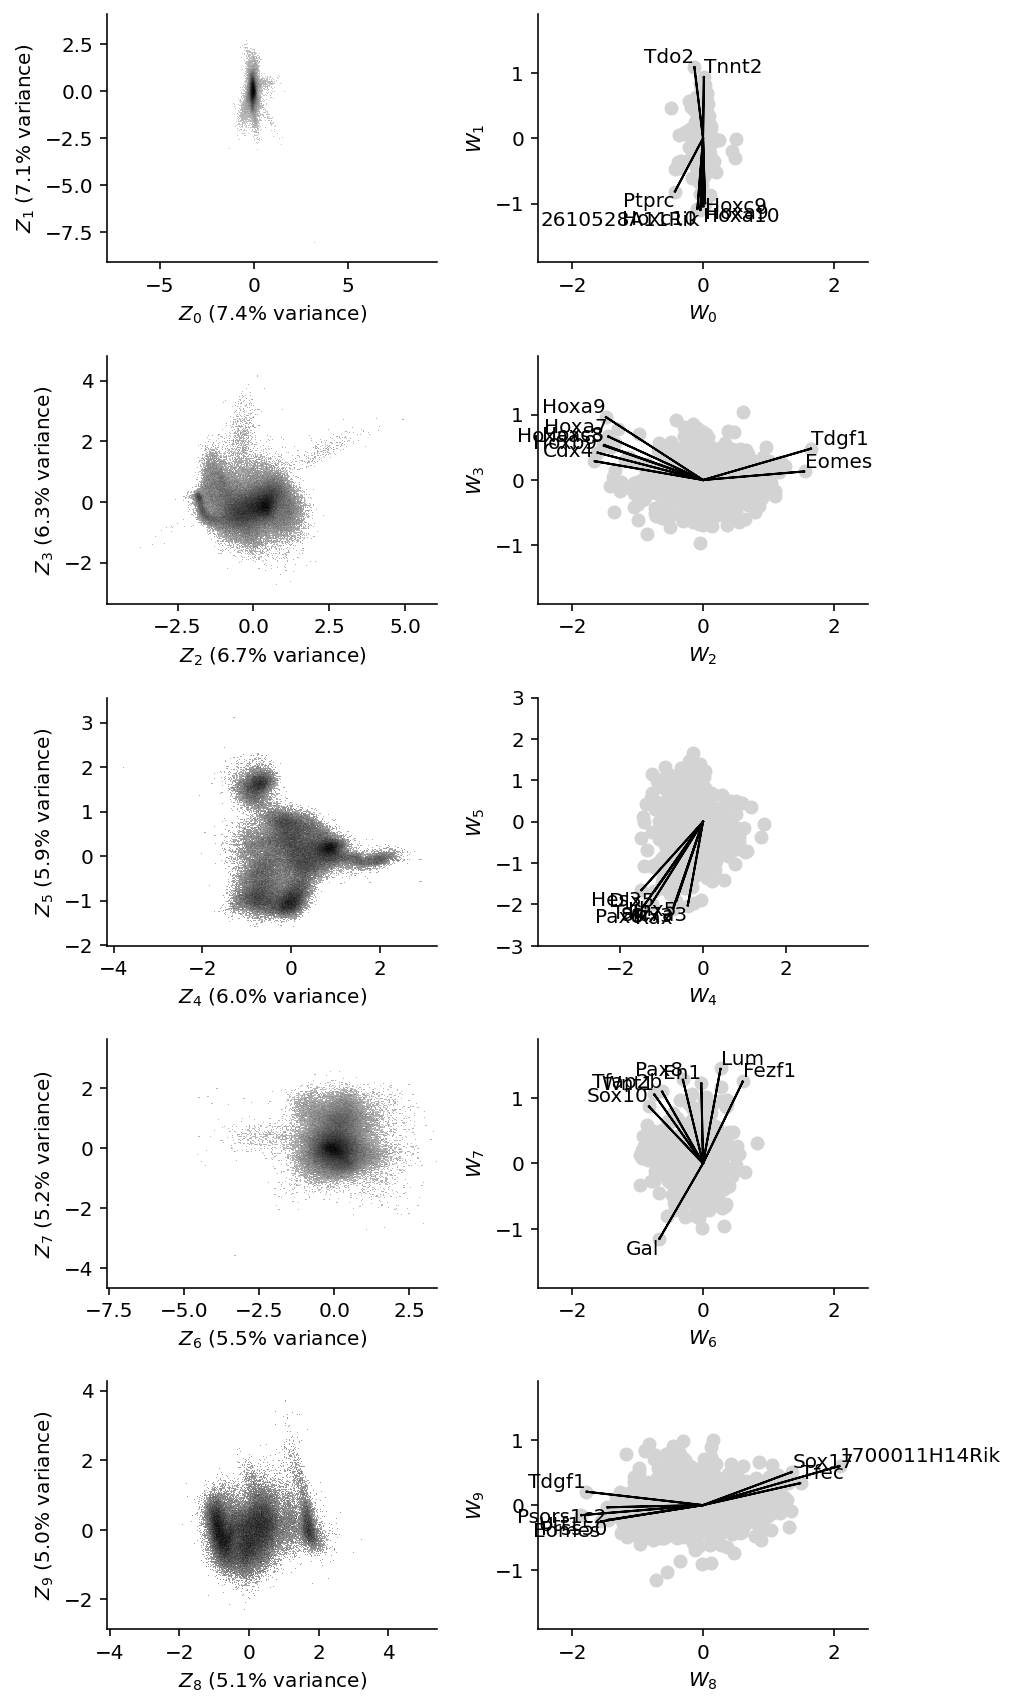

In [112]:
figsize(7, 12)
for i in range(5):
    
    # -- Z plot --
    
    plt.subplot(5, 2, 2 * i + 1)
    
    plt.hist2d(
        Z_df_ordered[f'z{2 * i}'], Z_df_ordered[f'z{2 * i + 1}'],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )
    plt.axis('equal');
    plt.xlabel(f'$Z_{2 * i}$ ({variance_explained[idx][2 * i]:.1%} variance)')
    plt.ylabel(f'$Z_{2 * i + 1}$ ({variance_explained[idx][2 * i + 1]:.1%} variance)')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # -- W plot --
    
    plt.subplot(5, 2, 2 * i + 2)
    
    w_columns = [f'w{2 * i}', f'w{2 * i + 1}']
    
    plt.scatter(
        W_df_ordered[w_columns[0]], W_df_ordered[w_columns[1]],
        c='lightgrey',
        rasterized=True
    )
    plt.axis('equal');
    plt.xlabel(f'$W_{2 * i}$')
    plt.ylabel(f'$W_{2 * i + 1}$')
    
    tmp_ = W_df_ordered.copy()
    tmp_['lnth'] = np.linalg.norm(tmp_[w_columns], axis=1)
    
    ggg = (
        tmp_
        .sort_values('lnth', ascending=False)
        .head(8)[['gene_name', 'lnth', *w_columns]]
    )
    print(ggg['gene_name'].values)
    
    texts = []
    arrows = []
    for g, r in ggg.iterrows():
        x_, y_ = r[w_columns[0]], r[w_columns[1]]
        
        ha = 'right'
        if x_ > 0:
            ha = 'left'
            
        va = 'top'
        if y_ > 0:
            va = 'bottom'
            
        arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True))
        
        xs, ys = 0, 0
        if (i, r.gene_name) in text_shift:
            xs, ys = text_shift[(i, r.gene_name)]
        
        texts.append(plt.text(x_ + xs, y_ + ys, r.gene_name, ha=ha, va=va))

    plt.xlim(left=-3, right=3)
    plt.ylim(bottom=-3, top=3)
        
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.savefig('figures/linear_pij_results.pdf', bbox_inches='tight', dpi=400)